## Dependencies

In [1]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [2]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Model parameters

In [4]:
# base_model_path = '/kaggle/input/efficientnet/'
dataset_path = 'melanoma-256x256'

config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 256,
  "EPOCHS": 30,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
#   "BASE_MODEL_PATH": base_model_path + 'efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5',
  "BASE_MODEL_PATH": 'imagenet11k-places365ch',
  "DATASET_PATH": dataset_path
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 256,
 'WIDTH': 256,
 'CHANNELS': 3,
 'BATCH_SIZE': 256,
 'EPOCHS': 30,
 'LEARNING_RATE': 0.0003,
 'ES_PATIENCE': 10,
 'N_FOLDS': 5,
 'BASE_MODEL_PATH': 'imagenet11k-places365ch',
 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = KaggleDatasets().get_gcs_path(dataset_path)
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [6]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [7]:
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.0003 to 1.2e-05


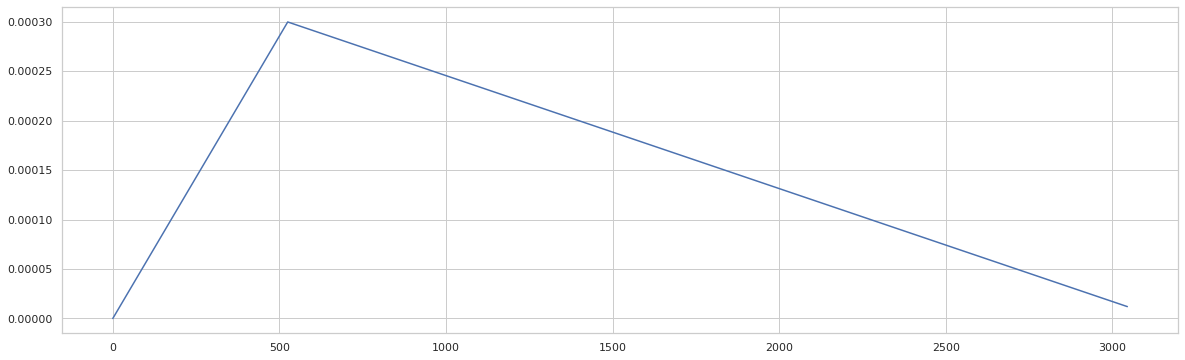

In [8]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 26880 // config['BATCH_SIZE'] #(len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) * 2) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, step_size)]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [9]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    BaseModel, preprocess_input = Classifiers.get('resnet50')
    base_model = BaseModel(input_shape=input_shape, 
                           weights=config['BASE_MODEL_PATH'], 
                           include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [10]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(len(k_fold)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    tf.tpu.experimental.initialize_tpu_system(tpu)
#     K.clear_session()
    
    ### Data
    train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    train_size = count_data_items(train_filenames)

    step_size = train_size // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
        
        lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                 total_steps=total_steps, warmup_steps=warmup_steps, 
                                                 hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                 lr_max=lr_max, lr_min=lr_min)
        
        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                      metrics=[metrics.AUC()])
    
    history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                               batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es], 
                        verbose=2).history
    
    history_list.append(history)
    
    # Make predictions
    preds = model.predict(image_data)
    name_preds = dict(zip(image_names, preds.reshape(len(preds))))
    k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)
    
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
    valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
    k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)


FOLD: 1
94593024/94592056 [==============================] - 1s 0us/step
Epoch 1/30
97/97 - 33s - auc: 0.6970 - loss: 0.1903 - val_auc: 0.5120 - val_loss: 0.1973
Epoch 2/30
97/97 - 15s - auc: 0.8161 - loss: 0.1689 - val_auc: 0.4737 - val_loss: 0.2216
Epoch 3/30
97/97 - 15s - auc: 0.8247 - loss: 0.1681 - val_auc: 0.5000 - val_loss: 0.2524
Epoch 4/30
97/97 - 18s - auc: 0.8310 - loss: 0.1672 - val_auc: 0.5048 - val_loss: 0.1834
Epoch 5/30
97/97 - 18s - auc: 0.8468 - loss: 0.1683 - val_auc: 0.4993 - val_loss: 0.1823
Epoch 6/30
97/97 - 18s - auc: 0.8262 - loss: 0.1675 - val_auc: 0.5033 - val_loss: 0.1738
Epoch 7/30
97/97 - 15s - auc: 0.8515 - loss: 0.1658 - val_auc: 0.5073 - val_loss: 0.1950
Epoch 8/30
97/97 - 15s - auc: 0.8308 - loss: 0.1674 - val_auc: 0.5103 - val_loss: 0.2198
Epoch 9/30
97/97 - 15s - auc: 0.8555 - loss: 0.1667 - val_auc: 0.7132 - val_loss: 0.1964
Epoch 10/30
97/97 - 16s - auc: 0.8600 - loss: 0.1660 - val_auc: 0.8246 - val_loss: 0.1748
Epoch 11/30
97/97 - 15s - auc: 0.86

## Model loss graph

Fold: 1


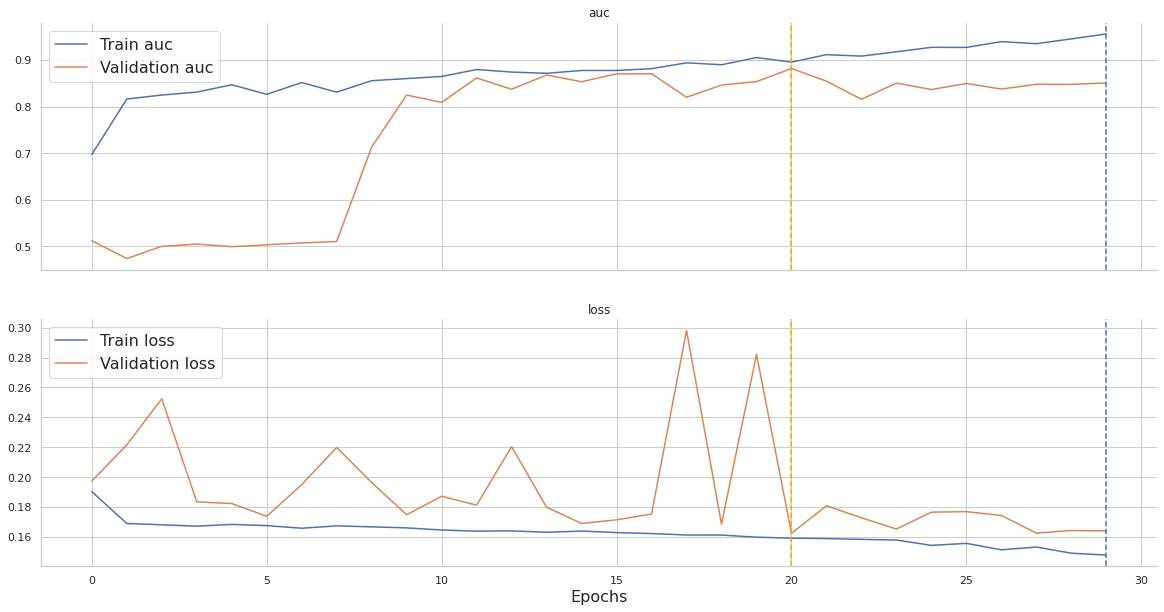

Fold: 2


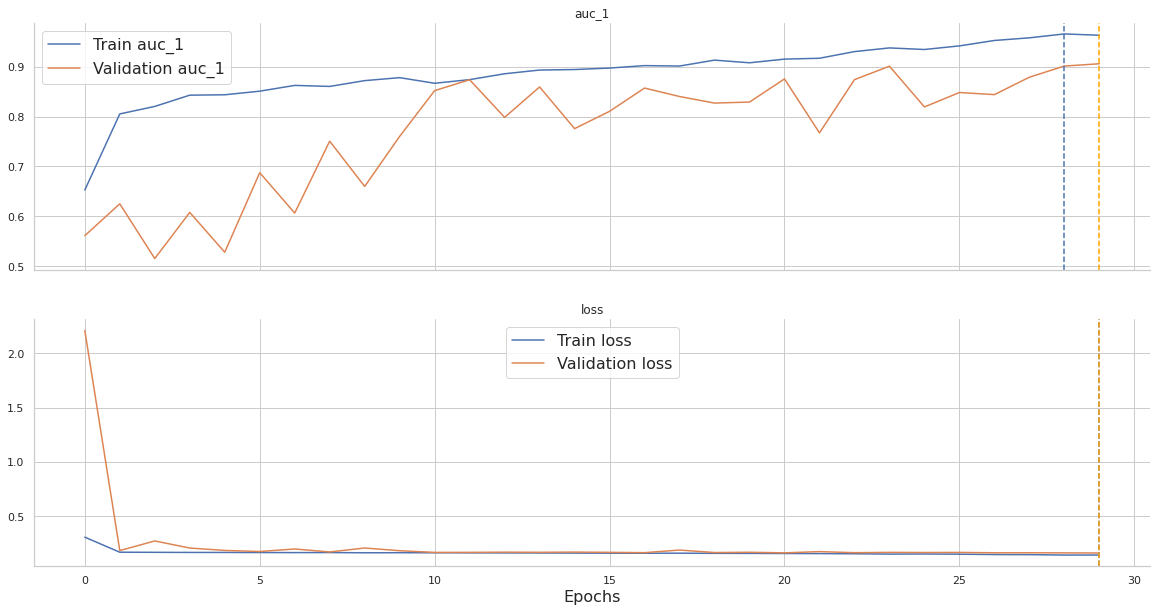

Fold: 3


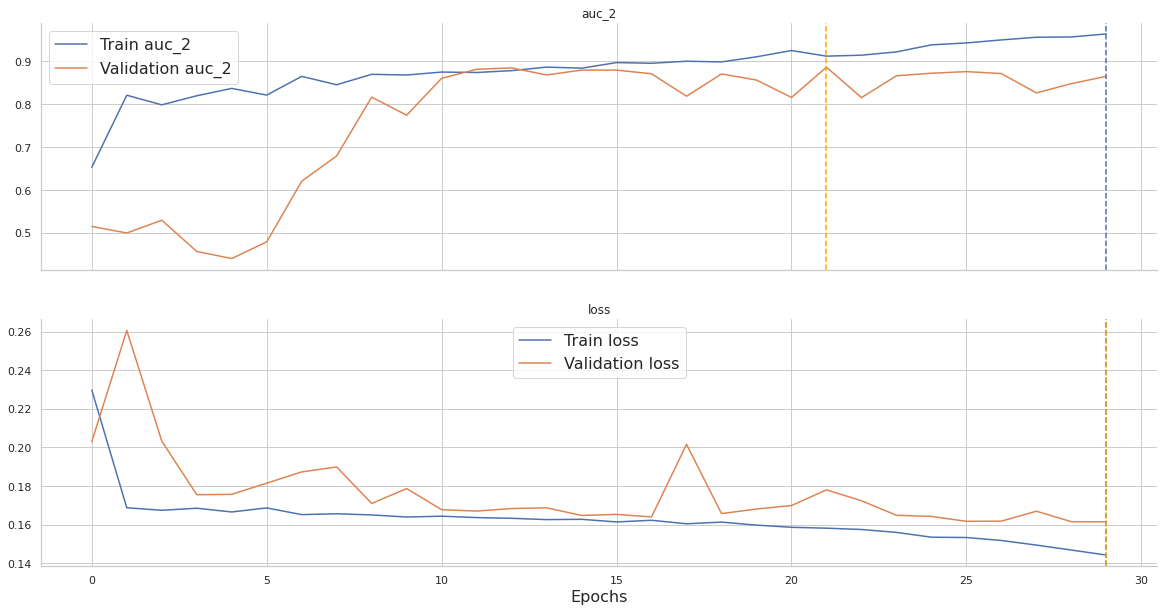

Fold: 4


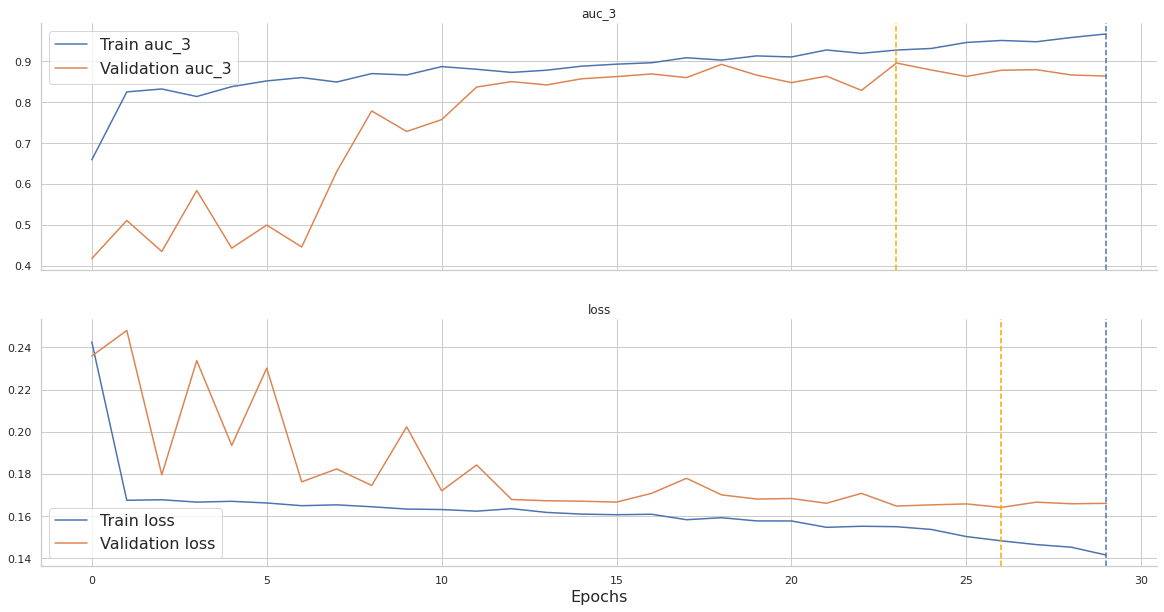

Fold: 5


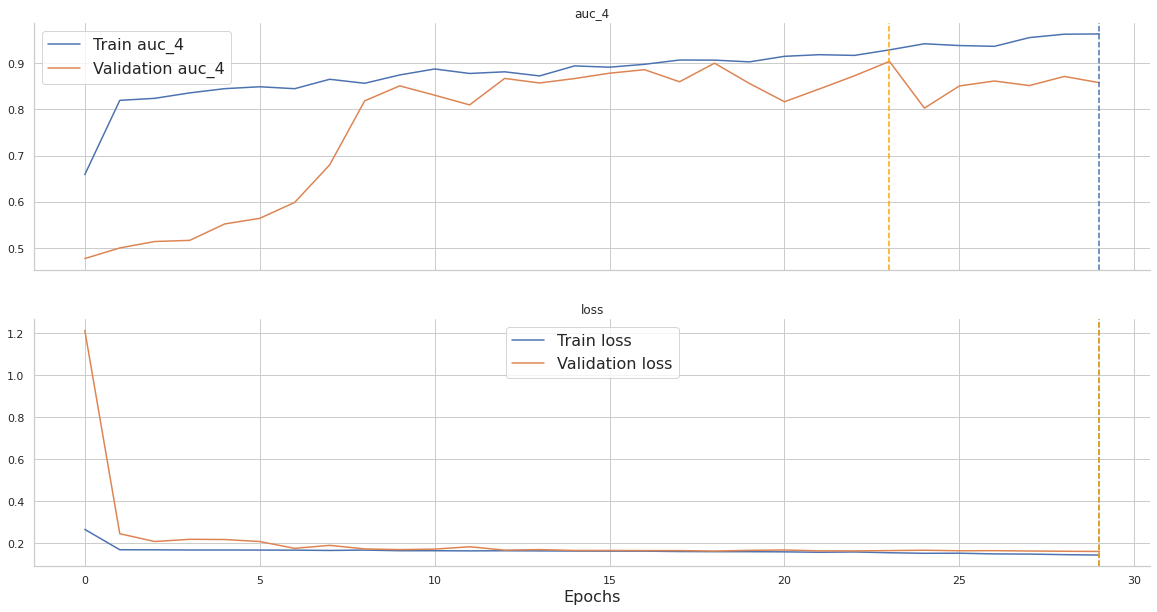

In [11]:
for n_fold in range(config['N_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

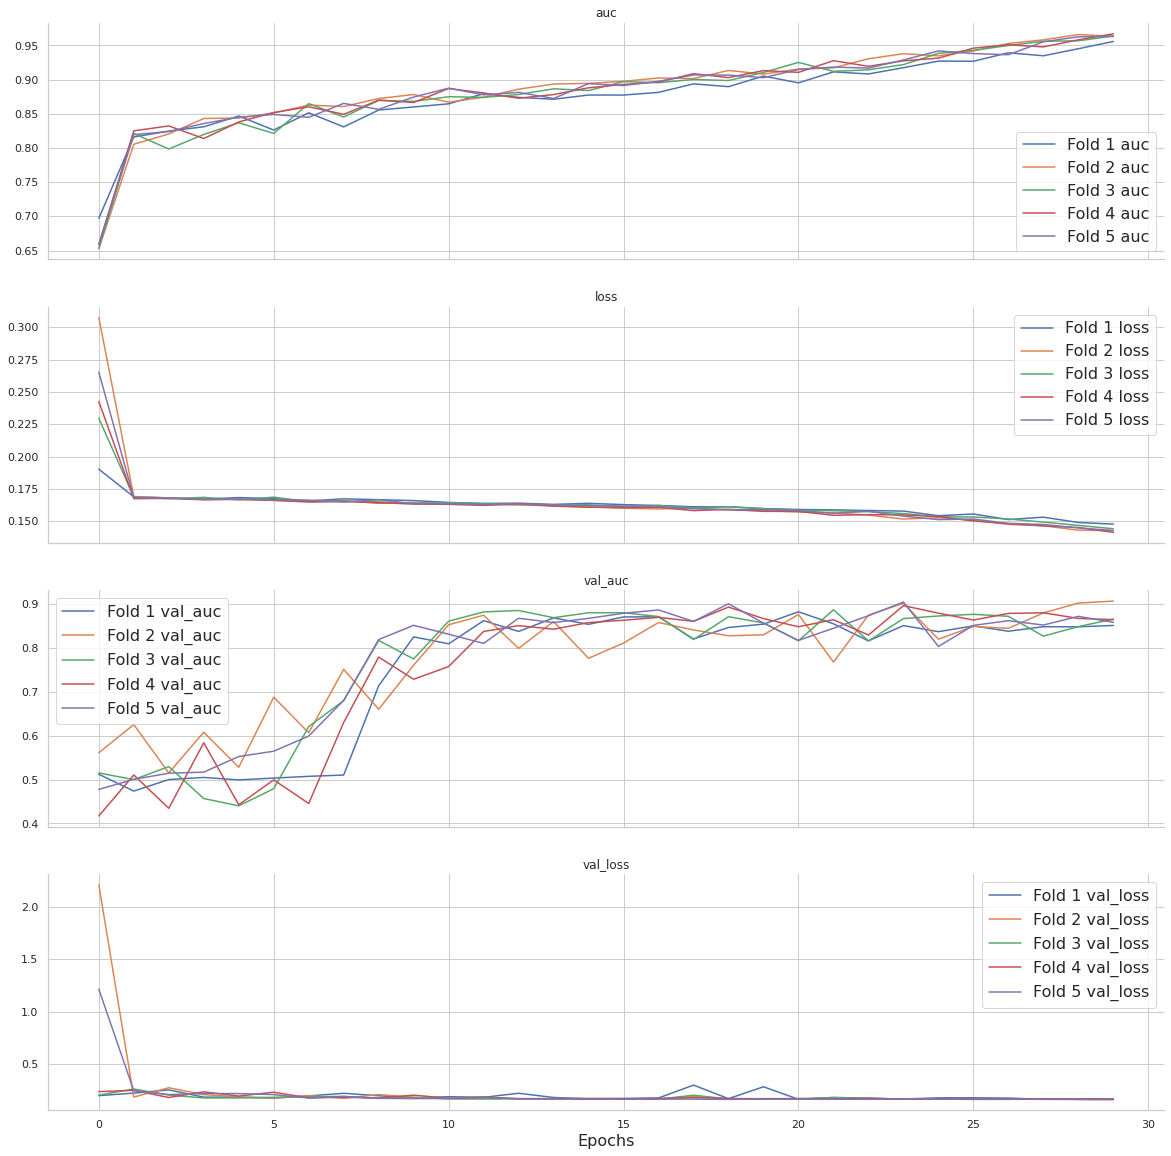

In [12]:
plot_metrics_agg(history_list, config['N_FOLDS'])

# Model evaluation

In [13]:
display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.988012,0.869718,0.118294,0.984684,0.855045,0.988961,0.903988,0.989135,0.868602,0.988063,0.865970,0.989216,0.854985
Accuracy,0.992632,0.982402,0.010230,0.990580,0.981410,0.993609,0.981651,0.992309,0.983422,0.993314,0.981299,0.993349,0.984227
Precision,0.930691,0.512810,0.417881,0.919679,0.348837,0.926554,0.461538,0.902439,0.604167,0.953416,0.441176,0.951368,0.708333
Recall,0.629070,0.174508,0.454562,0.516930,0.106383,0.691983,0.218182,0.628450,0.256637,0.650424,0.133929,0.657563,0.157407
F1-score,0.749197,0.256529,0.492668,0.661850,0.163043,0.792271,0.296296,0.740926,0.360248,0.773300,0.205479,0.777640,0.257576
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


# Model evaluation by Subset

In [14]:
display(evaluate_model_Subset(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.988012,0.869718,0.118294,0.984684,0.855045,0.988961,0.903988,0.989135,0.868602,0.988063,0.865970,0.989216,0.854985
male,0.988142,0.876915,0.111227,0.983999,0.872253,0.990947,0.896227,0.987351,0.889285,0.989288,0.885649,0.989125,0.841160
female,0.987415,0.857465,0.129950,0.984974,0.828316,0.985869,0.921199,0.991338,0.824431,0.985949,0.839051,0.988946,0.874329
head/neck,0.988315,0.811293,0.177021,0.985114,0.810930,0.990764,0.797262,0.981857,0.881115,0.987558,0.792516,0.996281,0.774644
upper extremity,0.990301,0.870500,0.119801,0.986455,0.866886,0.986127,0.931637,0.993510,0.841041,0.994376,0.862991,0.991038,0.849944
lower extremity,0.979759,0.818879,0.160881,0.976111,0.765370,0.983045,0.874355,0.985307,0.782875,0.973352,0.847539,0.980981,0.824255
torso,0.990785,0.908272,0.082513,0.987590,0.904019,0.991486,0.937837,0.991629,0.902934,0.992829,0.892606,0.990391,0.903963
0 <= age < 26,0.945764,0.722990,0.222774,0.958501,0.960490,0.935488,0.685615,0.968229,0.768585,0.908402,0.681659,0.958200,0.518601
26 <= age < 40,0.987968,0.807198,0.180770,0.975702,0.737381,0.995678,0.767354,0.990901,0.796180,0.991808,0.937236,0.985751,0.797840


# Confusion matrix

Fold: 1


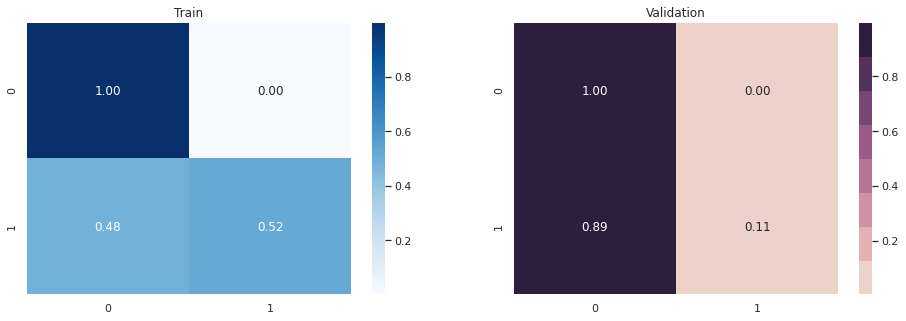

Fold: 2


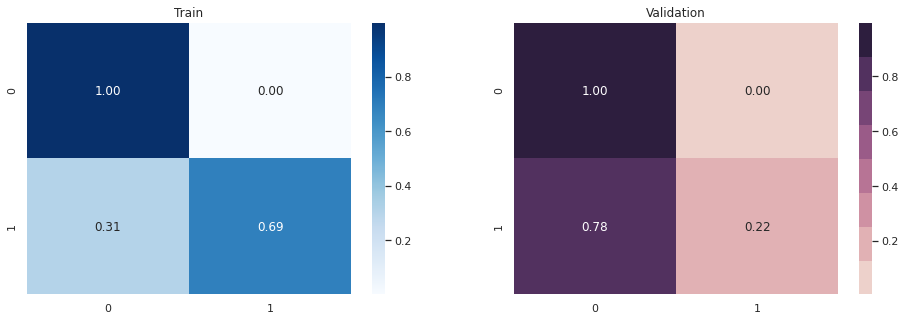

Fold: 3


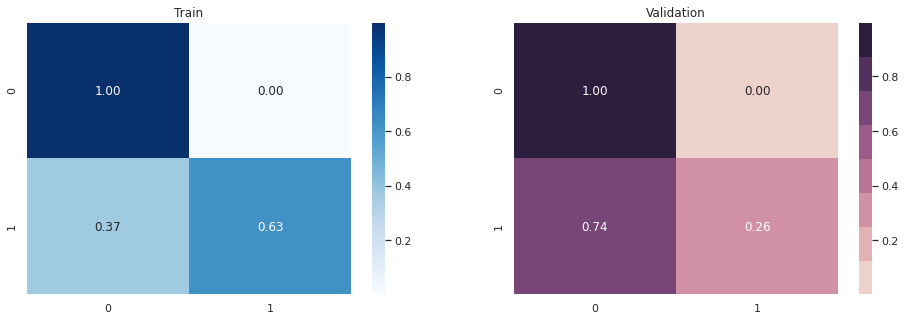

Fold: 4


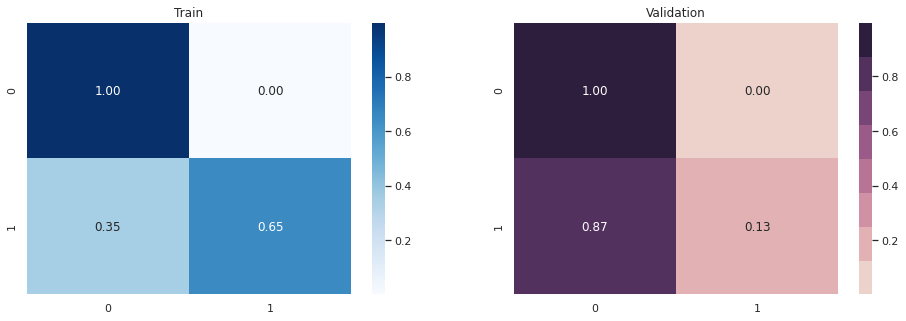

Fold: 5


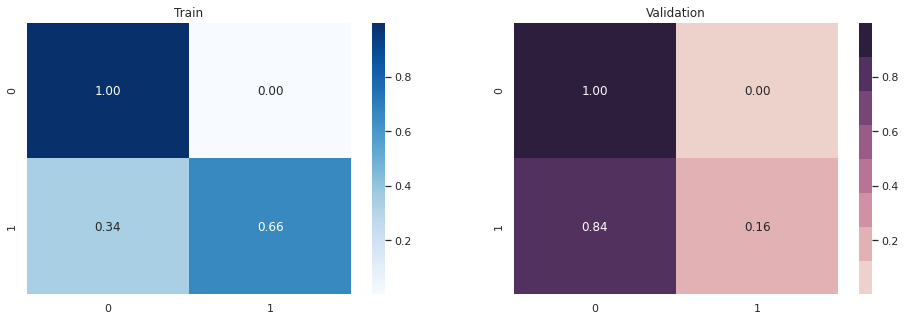

In [15]:
for n_fold in range(config['N_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [16]:
k_fold['pred'] = 0
for n_fold in range(config['N_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.024643,0.024938,0.023476,0.020858,0.028315,0.025628
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.029681,0.041862,0.026853,0.026692,0.026068,0.026930
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.027110,0.028653,0.027918,0.020631,0.030333,0.028016
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.028573,0.038221,0.017810,0.023926,0.028665,0.034241
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.026095,0.031889,0.022642,0.023862,0.025317,0.026767
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.024223,0.029467,0.025553,0.022158,0.023238,0.020700
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.031023,0.047250,0.021966,0.034580,0.026701,0.024617
7,ISIC_0075663,female,35.0,torso,unknown,0,0.020420,0.020317,0.021201,0.025549,0.019121,0.015913
8,ISIC_0075914,male,30.0,torso,unknown,0,0.026447,0.031942,0.024799,0.023650,0.027146,0.024698
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.032599,0.041378,0.028842,0.035951,0.027871,0.028954


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.438478,0.034816,0.417251,0.337371,0.919747,0.483206
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.499098,0.050543,0.934054,0.217790,0.571118,0.721983
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.397784,0.565264,0.225908,0.025310,0.953781,0.218655
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.470842,0.147162,0.961281,0.414409,0.415546,0.415812
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.577191,0.031736,0.718851,0.656590,0.979191,0.499590
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.790079,0.997794,0.938117,0.982989,0.071483,0.960010
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.222184,0.238057,0.044887,0.218152,0.562245,0.047579
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.723570,0.141625,0.911114,0.871018,0.796575,0.897516
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.573174,0.259891,0.700070,0.929782,0.644096,0.332030
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.488794,0.683829,0.991260,0.031570,0.066942,0.670365


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.577191,0.031736,0.718851,0.656590,0.979191,0.499590
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.790079,0.997794,0.938117,0.982989,0.071483,0.960010
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.723570,0.141625,0.911114,0.871018,0.796575,0.897516
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.573174,0.259891,0.700070,0.929782,0.644096,0.332030
580,ISIC_0280912,male,70.0,torso,melanoma,1,0.594374,0.046876,0.551087,0.514245,0.891812,0.967849
607,ISIC_0286360,male,60.0,upper extremity,melanoma,1,0.682200,0.475828,0.981300,0.877345,0.100780,0.975745
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.966133,0.998431,0.975434,0.861445,0.998041,0.997314
826,ISIC_0351666,male,80.0,head/neck,melanoma,1,0.843215,0.522487,0.894531,0.980690,0.971094,0.847273
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.587080,0.517247,0.561209,0.580259,0.759575,0.517110
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.976839,0.994922,0.965029,0.937895,0.991261,0.995088


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 344
Train positive correct predictions: 340


# Make predictions

In [17]:
model_path_list = glob.glob('/kaggle/working/' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

5 Models to predict:
/kaggle/working/model_fold_1.h5
/kaggle/working/model_fold_2.h5
/kaggle/working/model_fold_3.h5
/kaggle/working/model_fold_4.h5
/kaggle/working/model_fold_5.h5


In [18]:
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    tf.tpu.experimental.initialize_tpu_system(tpu)
#     K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset) / n_models


image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/kaggle/working/model_fold_1.h5
/kaggle/working/model_fold_2.h5
/kaggle/working/model_fold_3.h5
/kaggle/working/model_fold_4.h5
/kaggle/working/model_fold_5.h5


# Visualize test predictions

In [19]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge','target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 45|10937
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0052060,male,70.0,NaN,0.023870
1,ISIC_0052349,male,40.0,lower extremity,0.021604
2,ISIC_0058510,female,55.0,torso,0.021962
3,ISIC_0073313,female,50.0,torso,0.024488
4,ISIC_0073502,female,45.0,lower extremity,0.033106
5,ISIC_0074618,male,50.0,lower extremity,0.029372
6,ISIC_0076801,male,45.0,upper extremity,0.027107
7,ISIC_0077586,male,50.0,lower extremity,0.044221
8,ISIC_0082004,female,45.0,torso,0.033771
9,ISIC_0082785,male,65.0,lower extremity,0.027837


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
403,ISIC_0481105,male,80.0,torso,0.611270
1069,ISIC_1030252,female,50.0,head/neck,0.556366
1408,ISIC_1364884,female,35.0,upper extremity,0.600139
1485,ISIC_1429763,male,45.0,head/neck,0.519953
1525,ISIC_1460169,male,55.0,head/neck,0.539750
1677,ISIC_1593714,female,50.0,lower extremity,0.538483
1718,ISIC_1637595,male,55.0,head/neck,0.683463
1764,ISIC_1670692,male,50.0,torso,0.637445
2116,ISIC_2002073,male,40.0,upper extremity,0.617330
2214,ISIC_2098553,male,55.0,torso,0.662295


# Test set predictions

In [20]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission.to_csv('submission.csv', index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
0,ISIC_0052060,0.023870
1,ISIC_0052349,0.021604
2,ISIC_0058510,0.021962
3,ISIC_0073313,0.024488
4,ISIC_0073502,0.033106
5,ISIC_0074618,0.029372
6,ISIC_0076801,0.027107
7,ISIC_0077586,0.044221
8,ISIC_0082004,0.033771
9,ISIC_0082785,0.027837


,target
count,10982.000000
mean,0.040585
std,0.055138
min,0.010232
25%,0.023235
50%,0.026016
75%,0.035457
max,0.942728
